In [1]:
import qiskit
import numpy as np

import json, glob, math

In [2]:
glob.glob("*")

['elephant QFT-Copy1.ipynb',
 'elephant QFT.ipynb',
 'main.py',
 'plot-tools.py',
 'PlotTools.py',
 'png-tools.py',
 'QHOMER_IQFT.ipynb',
 'QHOMER_Optimizer_Function_FIXED.ipynb',
 'README.md',
 'Resources',
 'VectorQraphics.py',
 '__pycache__']

In [3]:
def qubits_necessary(n):
    """log2 of n"""
    l2 = math.log2(n)
    assert l2 % 1 == 0, "not an integer power of 2"
    return int(l2)

def normalized(arr):
    """l2-normalization"""
    return arr / np.linalg.norm(arr, 2)

## Data Loading

In [197]:
with open("./Resources/elephant.3.json") as f:
    data = json.load(f)[:-1]
    data = normalized(np.array([complex(a, b) for a, b in data]))
    #data = np.round(data, 2)

In [198]:
data

array([-0.33540909-0.20464924j, -0.35067741+0.02636224j,
       -0.37216689+0.21461861j,  0.25072113+0.20365533j,
        0.24696082+0.33781225j,  0.30969593+0.03918123j,
        0.1984365 -0.23399209j, -0.06801846-0.24846435j])

## Classical FT

In [199]:
data_ft = normalized(np.fft.fft(data))

In [200]:
data_ft

array([-0.04258815+0.04756141j, -0.18224408-0.02087657j,
        0.06916728+0.13301408j, -0.00990328-0.19188476j,
       -0.14280016+0.03289994j,  0.08766204+0.0407759j ,
       -0.00886371-0.0251545j , -0.7191101 -0.59517097j])

## State Loading

In [201]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute

In [202]:
def to_statevector(self, config={}):
    job = execute(
        self,
        Aer.get_backend("statevector_simulator"),
        **config
    )
    return job.result().get_statevector()

QuantumCircuit.to_statevector = to_statevector

In [295]:
def QHomer_Init(data_ft):
    """creates an initialization circuit creating a state with data_ft as coefficients"""
    # number of qubits necessary
    qubit_count = qubits_necessary(len(data_ft))
    #print(f"need {qubit_count} qubits")

    # quantum and classical registers
    qregs = QuantumRegister(qubit_count)
    #cregs = ClassicalRegister(qubit_count)

    # array of complex amplitudes
    desired_state = data_ft

    # initialization circut
    circuit = QuantumCircuit(qregs, name="data_loader_trivial")
    circuit.initialize(desired_state, range(qubit_count))
    
    return circuit

## Inverse QFT

In [296]:
def QHomer_IQFT(circuit):
    from qiskit.aqua.components.iqfts.standard import Standard as StandardIQFT

    IQFT = StandardIQFT(len(circuit.qubits))
    iqft = IQFT.construct_circuit(mode="circuit", qubits=circuit.qubits, circuit=circuit)

    return iqft


## Simulate and Measure

In [318]:
from qiskit.providers.aer import noise
from qiskit import IBMQ, transpile
from qiskit.ignis.verification.tomography import StateTomographyFitter, state_tomography_circuits

In [298]:
from qiskit.providers.aer.extensions import snapshot_density_matrix


In [300]:
# only execute to save account
# IBMQ.save_account('APIKEY', overwrite=True)

IBMQ.load_account()

# check whether we have accounts
assert len(IBMQ.providers()) > 0, "no account loaded. Save one with the command above"

IBMQ_cloud = IBMQ.providers()[0]
IBMQ_cloud.backends()

/home/johannes/miniconda3/envs/qiskit/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqfactory.py:181: UserWarning: Credentials are already in use. The existing account in the session will be replaced.
  warnings.warn('Credentials are already in use. The existing '


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx4') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_vigo') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_ourense') from IBMQ(hub='ibm-q', group='open', project='main')>]

In [540]:
def QHomer_Cheap_Mans_Tomography(data_ft, config={}, cheat=True):
    simulator = Aer.get_backend("qasm_simulator")
    n_qubits = qubits_necessary(len(data_ft))
    
    circuit_init = QHomer_Init(data_ft)
    circuit_init = transpile(circuit_init, basis_gates=['u1', 'u2', 'u3', 'cx'])
    circuit_iqft = QHomer_IQFT(circuit_init)
    
    if cheat:
        #return circuit_iqft.to_statevector()
        
        circuit_iqft.snapshot_density_matrix("final_state")
        opts = {"method": "density_matrix"}
        job = execute(circuit_iqft, simulator, shots=1, backend_options=opts)
        
        data = job.result().data(0)
        snapshot = np.array(data["snapshots"]["density_matrix"]["final_state"])
        rho = (snapshot[:, :, :, 0] + 1.0j*snapshot[:, :, :, 1])[0]
        
        #return rho
        
        evals, evecs = np.linalg.eigh(rho)
        largest_eval_idx = np.argmax(np.abs(evals))
        return normalized(evecs.T[largest_eval_idx])
    
    # full tomography    
    measured_qubits = circuit_iqft.qubits
    tomography_circuits = state_tomography_circuits(circuit_iqft, measured_qubits)
    
    tomography_results = StateTomographyFitter(execute(
            tomography_circuits,
            Aer.get_backend('statevector_simulator'),
            shots=1,
            **config,
        ).result(),
        tomography_circuits
    ).fit('auto')
    
    rho = np.array(tomography_results)
    evals, evecs = np.linalg.eig(rho)
    tomography_guess = evecs[np.argmax(np.abs(evals))]
    return tomography_guess

In [427]:
# Choose a real device to simulate
device = IBMQ_cloud.get_backend("ibmqx4")
properties = device.properties()

# Generate an Aer noise model for device
noise_model = noise.device.basic_device_noise_model(properties)

config = {
    "noise_model": noise_model,
    "basis_gates": noise_model.basis_gates
}

In [541]:
phase_tomography_results = QHomer_Cheap_Mans_Tomography(data_ft, config={}, cheat=True)

No classical registers in circuit "data_loader_trivial": result data will not contain counts.
No measurements in circuit "data_loader_trivial": count data will return all zeros.


## Recreate Original

In [366]:
from PlotTools import plot

import functools

In [542]:
xs, ys = np.real(phase_tomography_results), np.imag(phase_tomography_results)
xs

array([ 0.39291293,  0.18747678, -0.0475197 , -0.28477871, -0.38676743,
       -0.3201016 ,  0.20591489,  0.28562404])

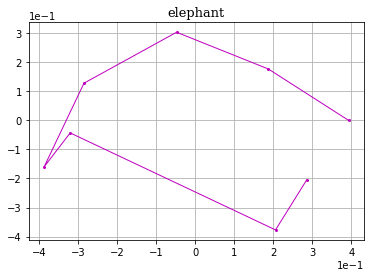

In [543]:
plot("elephant", xs, ys, linestyle="-")

In [ ]:
array([ 0.07128576, -0.13972766, -0.30669383, -0.17740376,  0.08692079,
       -0.01553225,  0.40815363,  0.25357059])